In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
from dash import html,dcc,Input,Output,Dash
from jupyter_dash import JupyterDash
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,multilabel_confusion_matrix,mean_squared_error
from xgboost import XGBRegressor,plot_importance,XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier

In [2]:
'''About this file

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea'''
df = pd.read_csv('./dataset/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [20]:
# app = Dash(__name__)
app = JupyterDash(__name__)
ml_models = {'RandomForestRegressor': RandomForestRegressor,
             'GradientBoostingRegressor':GradientBoostingRegressor,
             'XGBRegressor':XGBRegressor}
cfm_models = {'RandomForestClassifier': RandomForestClassifier,
              'GradientBoostingClassifier':GradientBoostingClassifier}
app.layout = html.Div(
            dbc.Container(
            [
                html.Div(
                [   
                    html.H1("Analytics Dashboard of California Housing", style={"textAlign":"center"}),
                    html.Hr(),
                    html.P('Scatter Plot By Selected Column:')
                ]),
                html.Div(
                [
                    dcc.Dropdown(id='scatter',
                             options=['housing_median_age','total_rooms','total_bedrooms',
                             'population','households','median_income','median_house_value'],
                             persistence='string',
                             persistence_type='local',
                             style={'width':'50%'}
                    ),
                    dcc.Graph(id='scatter_plot')
                ]),
                html.Div(
                [   html.P('Heatmap By Selected Column:'),
                    dcc.Dropdown(id='heatmap',
                             options=['housing_median_age','total_rooms','total_bedrooms',
                             'population','households','median_income','median_house_value'],
                             persistence='string',
                             persistence_type='local',
                             style={'width':'50%'}
                    ),
                    dcc.Graph(id='density_heatmap')
                ]),
                html.Div(
                [
                    html.P('ML Algo:'),
                    dcc.Dropdown(id='ml_method',
                            options=['GradientBoostingRegressor','RandomForestRegressor',
                                     'XGBRegressor'],
                            persistence='string',
                            persistence_type='local',
                            style={'width':'55%'}
                    ),
                    html.P('Accuracy: '),
                    html.Div(id='ml_result',style={'display':'inline-block'}),
                    html.P('median_house_value: ',style={'display': 'inline-block'}),
                    html.Div(id='ml_result',style={'display':'inline-block'})
                ]),
                html.Div(
                [   
                    html.P('Confusion Matrix'),
                    dcc.Dropdown(id='cfm_method',
                            options=['GradientBoostingClassifier','RandomForestClassifier'],
                            persistence='string',
                            persistence_type='local',
                            style={'width':'55%'}
                    ),
                    dcc.Graph(id='cm',style={'width':'50%','display': 'inline-block'})
                ])
                   
            ]
        )
)

@app.callback(
    Output('scatter_plot','figure'),
    Input('scatter','value')
)

def show_scatter_plot(select_col):
    px.set_mapbox_access_token(open("./dataset/mapbox_token.txt").read())
    fig = px.scatter_mapbox(df,lat='latitude',lon='longitude',
                            color='ocean_proximity',size=select_col,zoom=3)
    fig.update_layout(title=f"Size By {select_col}",mapbox_style='open-street-map')
    return fig

@app.callback(
    Output('density_heatmap','figure'),
    Input('heatmap','value')
)

def show_heatmap(select_col):
    px.set_mapbox_access_token(open("./dataset/mapbox_token.txt").read())
    fig = px.density_mapbox(df,lat='latitude',lon='longitude',z=select_col,radius=10,zoom=3)
    fig.update_layout(title=f"DensityMap By {select_col}",mapbox_style='carto-positron')
    return fig

@app.callback(
    Output('ml_result','children'),
    Input('ml_method','value')
)


def show_ml_metric(ml_method):
    df2 = df.copy()
    df2 = df2.drop(['longitude','latitude'],axis=1)
    df2 = df2.dropna()
    X = df2.drop(['median_house_value','ocean_proximity'],axis=1)
    y = df2['median_house_value']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)
    
    model = models[ml_method]()
    model.fit(X_train,y_train)
    
    score = model.score(X_test, y_test)
    pred = model.predict(X_test)
    mse = round(mean_squared_error(pred,y_test),3)
    return score,mse

@app.callback(
    Output('cm','figure'),
    Input('cfm_method','value')
)

def confusion_matrix(cfm_method):
    from sklearn.metrics import confusion_matrix
    df2 = df.copy()
    df2 = df2.drop(['longitude','latitude'],axis=1)
    df2 = df2.dropna()
    X = df2.drop(['ocean_proximity'],axis=1)
    y = df2['ocean_proximity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)
    
    model = cfm_models[cfm_method]()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    name_list = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
    cf_matrix = confusion_matrix(y_test,pred)
    fig = px.imshow(cf_matrix,text_auto=True,x=name_list[::-1],
              y=name_list,color_continuous_scale=px.colors.sequential.Viridis)
    return fig
    
    
if __name__ == '__main__':
    # 'external' or 'inline'
    app.run_server(mode="external",debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

# 機器學習

In [6]:
df2 = df.copy()
df2 = df2.drop(['longitude','latitude'],axis=1)
df2 = df2.dropna()
df2.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 預測房價中位數(median_house_value)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df2.drop(['median_house_value','ocean_proximity'],axis=1)
y = df2['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)
score = rf_model.score(X_test, y_test)
print('Accuracy:',round(score,3))

pred = rf_model.predict(X_test)
print('MSE:',round(mean_squared_error(pred,y_test),3))
score

Accuracy: 0.661
MSE: 4551503429.698


0.6609651088874201

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gdb_model = GradientBoostingRegressor()
gdb_model.fit(X_train,y_train)
score = gdb_model.score(X_test, y_test)
print('Accuracy:',round(score,3))

pred = gdb_model.predict(X_test)
print('MSE:',round(mean_squared_error(pred,y_test),3))

Accuracy: 0.648
MSE: 4726762434.0


In [51]:
from xgboost import XGBRegressor,plot_importance

xgb_model = XGBRegressor(max_depth=6)
xgb_model.fit(X_train,y_train)
score = xgb_model.score(X_test, y_test)
print('Accuracy:',round(score,3))

pred = xgb_model.predict(X_test)
print('MSE:',round(mean_squared_error(pred,y_test),3))
print(xgb_model.get_booster().get_score())
# plot_importance(xgb_model)
# print(xgb_model.get_booster().get_fscore())

Accuracy: 0.66
MSE: 4565375194.531
{'housing_median_age': 834.0, 'total_rooms': 915.0, 'total_bedrooms': 711.0, 'population': 854.0, 'households': 573.0, 'median_income': 869.0}


# 預測房屋是否靠近加州灣區

In [93]:
X = df2.drop(['ocean_proximity'],axis=1)
y = df2['ocean_proximity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,multilabel_confusion_matrix
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
# score = rf_model.score(X_test, y_test)
# print('Accuracy:',round(score,3))

pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))
print(multilabel_confusion_matrix(y_test,pred))


[[2559  230    0  128   73]
 [ 338 1762    0   19   19]
 [   0    0    0    1    1]
 [ 434   99    0  191   30]
 [ 563  171    0   47   78]]
              precision    recall  f1-score   support

   <1H OCEAN       0.66      0.86      0.74      2990
      INLAND       0.78      0.82      0.80      2138
      ISLAND       0.00      0.00      0.00         2
    NEAR BAY       0.49      0.25      0.34       754
  NEAR OCEAN       0.39      0.09      0.15       859

    accuracy                           0.68      6743
   macro avg       0.46      0.40      0.41      6743
weighted avg       0.64      0.68      0.64      6743

[[[2418 1335]
  [ 431 2559]]

 [[4105  500]
  [ 376 1762]]

 [[6741    0]
  [   2    0]]

 [[5794  195]
  [ 563  191]]

 [[5761  123]
  [ 781   78]]]


C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



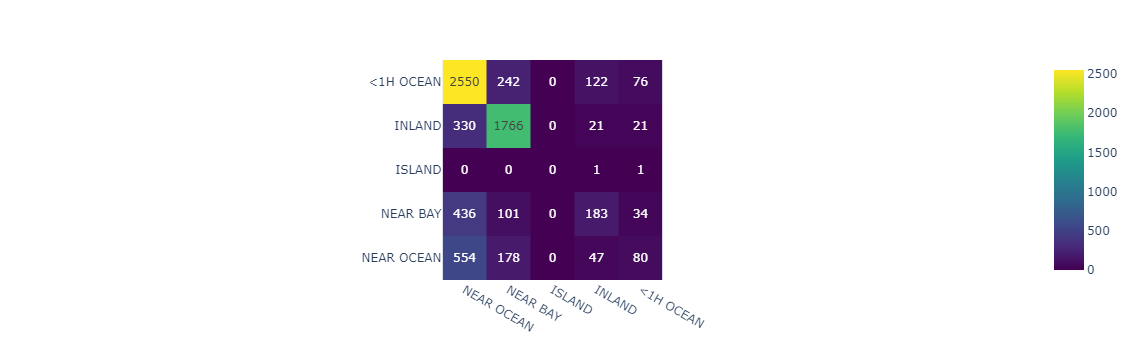

In [110]:
from sklearn.metrics import confusion_matrix
temp = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

px.imshow(confusion_matrix(y_test, pred),text_auto=True,
         x=temp[::-1],y=temp,color_continuous_scale=px.colors.sequential.Viridis)

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

lg_model = GradientBoostingClassifier()
lg_model.fit(X_train,y_train)
score = lg_model.score(X_test, y_test)
print('Accuracy:',round(score,3))

pred = lg_model.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))
print(multilabel_confusion_matrix(y_test,pred))

Accuracy: 0.678
[[2616  240    0  113   21]
 [ 370 1736    0   23    9]
 [   1    0    0    1    0]
 [ 461   94    0  197    2]
 [ 617  171    0   47   24]]
              precision    recall  f1-score   support

   <1H OCEAN       0.64      0.87      0.74      2990
      INLAND       0.77      0.81      0.79      2138
      ISLAND       0.00      0.00      0.00         2
    NEAR BAY       0.52      0.26      0.35       754
  NEAR OCEAN       0.43      0.03      0.05       859

    accuracy                           0.68      6743
   macro avg       0.47      0.40      0.39      6743
weighted avg       0.64      0.68      0.63      6743

[[[2304 1449]
  [ 374 2616]]

 [[4100  505]
  [ 402 1736]]

 [[6741    0]
  [   2    0]]

 [[5805  184]
  [ 557  197]]

 [[5852   32]
  [ 835   24]]]


C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\10011\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



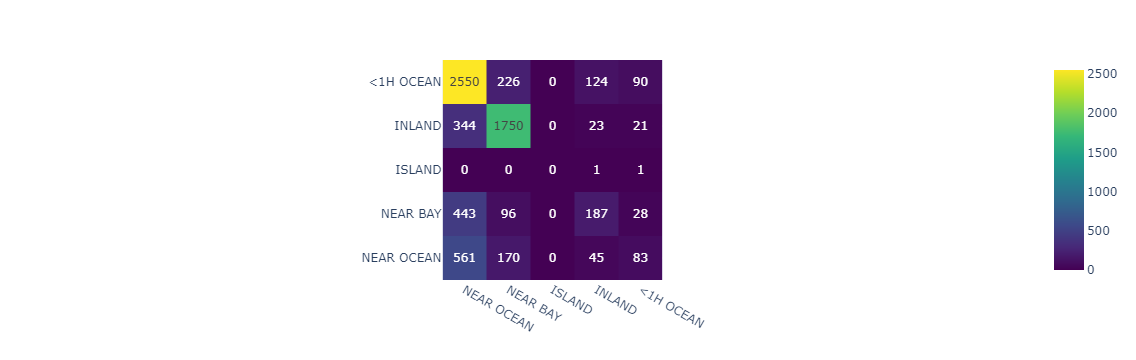

In [113]:
from sklearn.metrics import confusion_matrix
df2 = df.copy()
df2 = df2.drop(['longitude','latitude'],axis=1)
df2 = df2.dropna()
X = df2.drop(['ocean_proximity'],axis=1)
y = df2['ocean_proximity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)

model = RandomForestClassifier()
model.fit(X_train,y_train)
pred = model.predict(X_test)
pred

name_list = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
cf_matrix = confusion_matrix(y_test,pred)
fig = px.imshow(cf_matrix,text_auto=True,x=name_list[::-1],
              y=name_list,color_continuous_scale=px.colors.sequential.Viridis)
fig